### 这里以番茄的 Solyc05g011970SOLA4（CYP749A20）和Solyc06g066830(DOX)的promoter为例.
- 从下游到上游的计算过程;

In [1]:
%load_ext autoreload
%autoreload 2
from Bio import SeqIO
from fimocistarget.fimo_cistarg import PyMEMESuiteCisTargetBuilder
from fimocistarget.cistarg_impl import GenomeBackgroundComparator
import pandas as pd
from Bio.Seq import Seq
from pathlib import Path
from utils.io_utils import batch_to_boltz_fasta, get_boltz_res
from cropd2p.cropdock.a3m import read_a3m
from utils.utils import calc_ipsae
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
geneids = ['Solyc05g011970.3', 'Solyc06g066830.3']
pro_seqs = SeqIO.to_dict(SeqIO.parse('data/genome/Sly/Sly_promoter.fasta', 'fasta'))

FileNotFoundError: [Errno 2] No such file or directory: 'data/genome/Sly/Sly_promoter.fasta'

In [ ]:
pro_seq = {gid:seq for gid,seq in pro_seqs.items() if gid in geneids}

In [ ]:
pymeme_builder = PyMEMESuiteCisTargetBuilder(
    motif_dir='data/PWM_DATABASE/Sly/pwms_all_memes',
    fasta_file='data/genome/Sly/Sly_promoter.fasta',
    output_dir='data/genome/Sly',
)

INFO:fimocistarget.fimo_cistarg:初始化完成
INFO:fimocistarget.fimo_cistarg:FASTA文件: data/genome/Sly/Sly_promoter.fasta
INFO:fimocistarget.fimo_cistarg:Motif目录: data/PWM_DATABASE/Sly/pwms_all_memes
INFO:fimocistarget.fimo_cistarg:P-value阈值: 0.0001


In [ ]:
# pymeme_builder.load_sequences()[0].name.decode()

In [ ]:
# score_matrix, ranking_db = pymeme_builder.build_database(aggregation_method='max')

In [ ]:
# from fimocistarget.cistarg_impl import CisTargetAnalyzer
# import pandas as pd


# analyzer = CisTargetAnalyzer(ranking_db, nes_threshold=1,auc_threshold=0.01)
# enriched_motifs = analyzer.run_cistarg(
#     ranking_db, 
#     return_target_regions=True
#     )

In [ ]:
fimo_res = pd.read_csv('data/genome/Sly/fimo_results_raw.csv')
gene1_fimo = fimo_res[fimo_res['sequence_name'] == geneids[1]] # 选出某个基因的结果

In [ ]:
tf_infos = pd.read_csv('data/PWM_DATABASE/Sly/TF_Information_all_motifs.txt', sep='\t')
tf_infos.columns = tf_infos.columns.str.lower()

In [ ]:
final_fimo = gene1_fimo.merge(tf_infos, on='motif_id', how='left')

In [ ]:
extend_length = 5
tf_fasta_dir = Path('data/MSA_DATABASE/sly_msa')
tf_fasta_lst = list(tf_fasta_dir.glob('*.fasta'))
msa_dir = {i.name:i for i in Path('data/MSA_DATABASE/sly_msa').iterdir() if i.is_dir()}

def help_rename_seqname(seq_file):
    seq_dct = SeqIO.to_dict(SeqIO.parse(seq_file, 'fasta'))
    seqs = {k.split('.')[0] + '.' + k.split('.')[1]: Seq(v.seq) for k, v in seq_dct.items()}
    return seqs

def get_tf_fasta(tf_fasta_lst):
    tf_fasta_dict = {}
    for tf_fasta in tf_fasta_lst:
        tf_fasta_dict.update(help_rename_seqname(tf_fasta))
    return tf_fasta_dict

def get_tf_msa_path(tf_fasta_lst, msa_dir_dct):
    tf_msa_path = {}
    for tf_fasta in tf_fasta_lst:
        try:
            msa_path = msa_dir_dct[tf_fasta.stem].joinpath('0.a3m')
            name = tf_fasta.stem.split('_')[0] + '.'+tf_fasta.stem.split('_')[1]
            tf_msa_path[name] = msa_path
        except:
            pass
    return tf_msa_path
        
tf_seq_dct = get_tf_fasta(tf_fasta_lst)
tf_msa_dct = get_tf_msa_path(tf_fasta_lst, msa_dir)

In [ ]:
# def help_crop_seq_base_fimo(down_gene, start,end, pro_seqs, extend_length=5):
#     down_gene_promoter = str(pro_seqs[down_gene].seq).upper()
#     s_e = np.array([start, end])
#     s = s_e.min()
#     e = s_e.max()
#     down_gene_promoter = Seq(down_gene_promoter[s-1-extend_length:e+extend_length+1])
#     return down_gene_promoter

# final_fimo['crop_seq'] = final_fimo.apply(lambda x: help_crop_seq_base_fimo(x.sequence_name, x.start, x.stop, pro_seqs), axis=1)

In [ ]:
# batch_to_boltz_fasta(
#     final_fimo   = final_fimo[final_fimo['motif_id'].isin(significant_motifs['motif'])], # 取出显著性富集的motifs
#     tf_msa_dct   = tf_msa_dct,
#     tf_seq_dct   = tf_seq_dct,
#     pro_seqs_dct = pro_seq,
#     save_dir     = f'data/genome/Sly/boltz_{target_gene}',
#     extend_length = 5)

In [ ]:
final_fimo['file_id'] = final_fimo.apply(lambda x: f'{x.tf_name}_{x.motif_id}_{x.sequence_name}_{x.start}_{x.stop}', axis=1)

In [ ]:
final_fimo_score  = final_fimo[['file_id', 'qvalue']]
final_fimo_score.set_index('file_id', inplace=True)
final_fimo_score

min_q_value = final_fimo_score[final_fimo_score['qvalue'] > 0]['qvalue'].min()
epsilon = min_q_value / 2  # 使用一个比最小非零值更小的值

# 创建一个新的列，避免修改原始数据
final_fimo_score['log_qvalue'] = 1 + np.log10(final_fimo_score['qvalue'] + epsilon)

/tmp/ipykernel_4000150/302852012.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_fimo_score['log_qvalue'] = 1 + np.log10(final_fimo_score['qvalue'] + epsilon)


In [ ]:
boltz_res_dir_g0     = Path(f'data/genome/Sly/boltz_Solyc05g011970.3_out/boltz_results_boltz_Solyc05g011970/predictions')
boltz_res_dir_g1     = Path(f'data/genome/Sly/boltz_Solyc06g066830.3_out/boltz_results_boltz_Solyc06g066830/predictions')
boltz_res_dir_g1_all = Path(f'data/genome/Sly/boltz_in1_out/boltz_results_boltz_in1/predictions')
g0  = get_boltz_res(boltz_res_dir_g0, res_type='iptm')
g1  = get_boltz_res(boltz_res_dir_g1, res_type='iptm')
g11 = get_boltz_res(boltz_res_dir_g1_all, res_type='iptm')

In [ ]:
g11

,boltzscan score
Solyc02g077960.1_M07268_3.00_Solyc06g066830.3_557_577,0.648515
Solyc02g088070.2_M07269_3.00_Solyc06g066830.3_82_100,0.563190
Solyc03g113270.2_M07313_3.00_Solyc06g066830.3_1243_1262,0.778446
Solyc09g014250.2_M07549_3.00_Solyc06g066830.3_1304_1290,0.910970
Solyc02g088070.2_M07264_3.00_Solyc06g066830.3_1207_1194,0.640717
...,...
Solyc08g082910.1_M07246_3.00_Solyc06g066830.3_2075_2089,0.932317
Solyc07g054840.2_M07509_3.00_Solyc06g066830.3_881_894,0.917010
Solyc10g005460.2_M07411_3.00_Solyc06g066830.3_841_861,0.827412
Solyc02g076850.1_M07238_3.00_Solyc06g066830.3_83_103,0.824426


In [ ]:
g0

,boltzscan score
Solyc06g035570.1_M07394_3.00_Solyc05g011970.3_1641_1624,0.845497
Solyc05g054660.1_M00931_3.00_Solyc05g011970.3_2069_2063,0.837221
Solyc02g091550.1_M07394_3.00_Solyc05g011970.3_865_882,0.825498
Solyc11g028020.1_M07394_3.00_Solyc05g011970.3_393_410,0.944949
Solyc10g086640.1_M02309_3.00_Solyc05g011970.3_1479_1472,0.968197
...,...
Solyc08g041820.2_M02309_3.00_Solyc05g011970.3_1479_1472,0.971480
Solyc02g065730.1_M07394_3.00_Solyc05g011970.3_412_395,0.938020
Solyc06g035570.1_M07391_3.00_Solyc05g011970.3_98_116,0.807091
Solyc12g038510.1_M07391_3.00_Solyc05g011970.3_1624_1642,0.925200


In [ ]:
g11.to_csv('data/boltzscan_Solyc06g066830.3.csv')
g0.to_csv('data/boltzscan_Solyc05g011970.3.csv')

In [ ]:
# g11_pae = get_boltz_res(boltz_res_dir_g1_all, res_type='pae')
# g11_cif = get_boltz_res(boltz_res_dir_g1_all, res_type='cif')
# for (k1,pae),(k2,cif) in zip(g11_pae.items(), g11_cif.items()):
#     assert k1 == k2, 'key not match'
#     try:
#         calc_ipsae(cif_file=cif, pae_file=pae, ipsae_script='cropd2p/cropdock/ipsae.py')
#     except Exception as e:
#         print(f'calc_ipsae failed for {k1}: {e}')

In [ ]:
a = g11.join(final_fimo_score)
a['log_qvalue'].corr(a['boltzscan score'])

np.float64(0.44479004548665957)

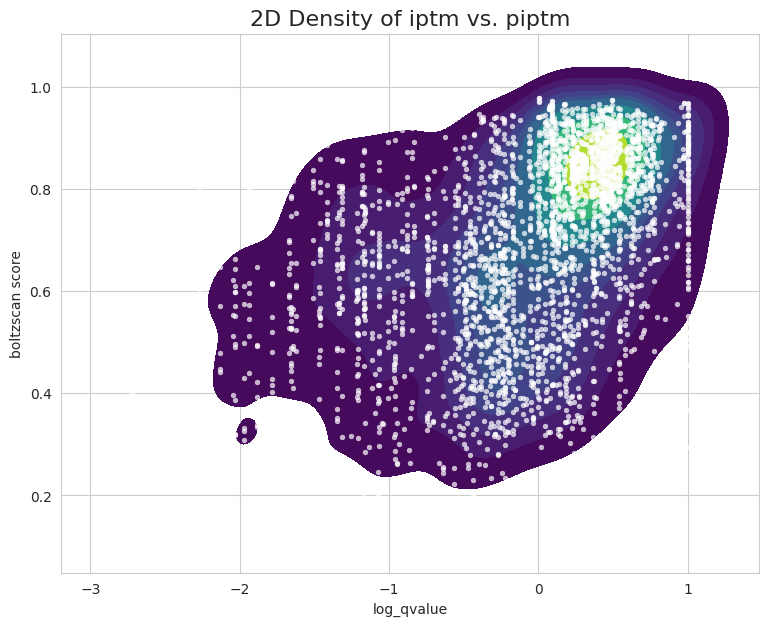

In [ ]:
plt.figure(figsize=(9, 7))
sns.kdeplot(
    data=a, 
    y='boltzscan score', 
    x='log_qvalue', 
    fill=True,      # 填充颜色
    thresh=0.05,    # 只显示密度高于5%的区域，避免图形过于杂乱
    cmap='viridis'  # 选择一个好看的色板
)

sns.scatterplot(
    data=a.sample(n=3000), # 只抽样一部分点，避免过饱和
    y='boltzscan score', 
    x='log_qvalue', 
    color='white', 
    alpha=0.7,
    s=12.5 # 点的大小
)

plt.title('2D Density of iptm vs. piptm', fontsize=16)
plt.show()

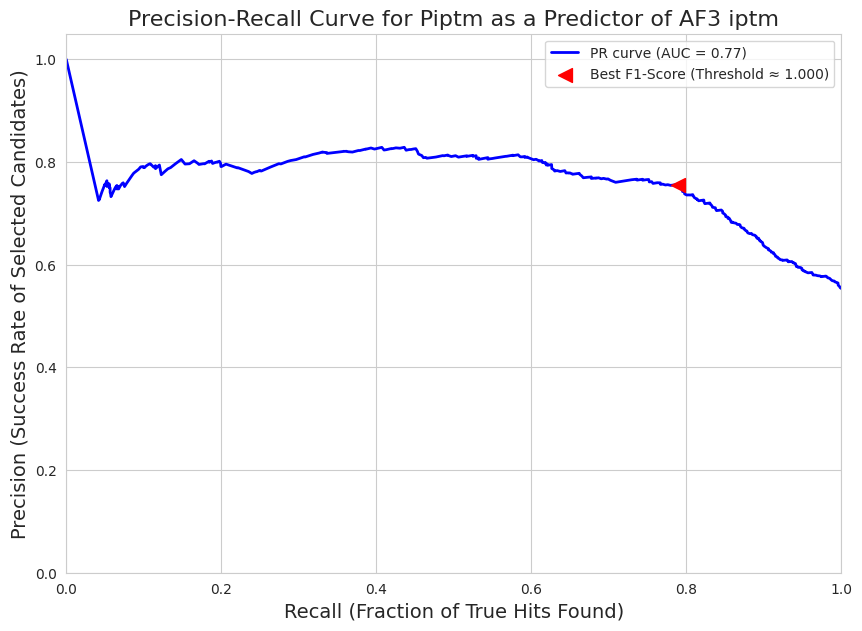

Optimal q-value threshold based on F1-score: 0.9998
At this threshold: Precision = 0.76, Recall = 0.79


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc


success_threshold = 0.7
y_true = (a['boltzscan score'] > success_threshold).astype(int)


y_scores = a['log_qvalue']
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 计算曲线下面积 (AUC-PR)，这是一个综合评价指标
pr_auc = auc(recall, precision)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 7))

plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')

plt.xlabel('Recall (Fraction of True Hits Found)', fontsize=14)
plt.ylabel('Precision (Success Rate of Selected Candidates)', fontsize=14)
plt.title('Precision-Recall Curve for Piptm as a Predictor of AF3 iptm', fontsize=16)
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# (可选，但非常有用) 找到F1分数最高的点，这通常是P和R之间的一个最佳平衡点
f1_scores = 2 * recall * precision / (recall + precision)
# 避免除以零
f1_scores = np.nan_to_num(f1_scores)
best_f1_idx = np.argmax(f1_scores)

plt.scatter(
    recall[best_f1_idx], 
    precision[best_f1_idx], 
    marker='<', 
    color='red', 
    s=100,
    zorder=10, # 确保点在最上层
    label=f'Best F1-Score (Threshold ≈ {1-thresholds[best_f1_idx]:.3f})' # 显示对应的q-value阈值
)
plt.legend()
plt.show()

print(f"Optimal q-value threshold based on F1-score: {1-thresholds[best_f1_idx]:.4f}")
print(f"At this threshold: Precision = {precision[best_f1_idx]:.2f}, Recall = {recall[best_f1_idx]:.2f}")

In [ ]:
y_scores[y_scores > thresholds[best_f1_idx]].count()

np.int64(7800)